In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import talib
import functions
from backtesting import Backtest, Strategy

/Users/jesse/miniforge3/lib/python3.9/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [2]:
_df = functions.get_data('2454.TW', '2017-05-25', '2022-05-26')
_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock splits,Foreign,Trust,Dealer,Total
Date,,,,,,,,,,,
2017-05-25,192.774853,197.926965,189.769455,196.209595,23568000,0.0,0,8029,286,884,9199
2017-05-26,197.068298,198.356326,195.350928,197.068298,12758000,0.0,0,3698,659,-1264,3093
2017-05-31,197.497650,199.215021,196.638965,197.497650,11672000,0.0,0,1618,108,-194,1532
2017-06-01,197.497629,198.356314,195.350916,195.780258,5294000,0.0,0,315,0,-213,102
2017-06-02,197.497647,202.649759,197.068304,200.932388,11260000,0.0,0,1989,126,1543,3658


In [3]:
# _df.to_csv('data/2454.csv')
# _df = pd.read_csv('data/2454.csv', index_col = 'Date')
# _df

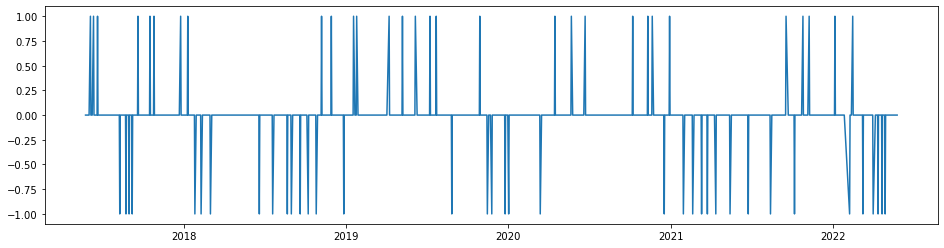

In [4]:
chip_df = functions.chip_signal(_df.copy())

plt.figure(figsize=(16, 4))
plt.plot(chip_df.index, chip_df.ChipSignal)
plt.show()

In [5]:
chip_df.ChipSignal.value_counts()

 0    1151
-1      37
 1      30
Name: ChipSignal, dtype: int64

## BBands w/ RSI

In [6]:
class BBands_RSI(Strategy):
    
    """
    Functions:
        def buy(self, *, size=.9999, limit=None, stop=None, sl=None, tp=None)
        def sell(self, *, size=.9999, limit=None, stop=None, sl=None, tp=None)
        def close(self, portion=1.0)
    
    Parameters:
        MA_Type: 0=SMA, 1=EMA, 2=WMA, 3=DEMA, 4=TEMA, 5=TRIMA, 6=KAMA, 7=MAMA, 8=T3 (Default=SMA)
    """
    
    matype = 0
    
    # n1: bbands (default: 5); n2: rsi (default: 14)
    n1 = 5
    n2 = 14
    
    def init(self):
        super().init()
        
        # Precompute the two moving averages
        close = pd.Series(self.data.Close)
        upper, middle, lower = talib.BBANDS(close, timeperiod=self.n1, matype=self.matype)
        rsi = talib.RSI(close, timeperiod=self.n2)
        
        # Precompute signal
        signal_long = (rsi.shift() > 50) & (rsi.shift() < 70) & (close < middle.shift())
        signal_short = (rsi.shift() < 50) & (rsi.shift() > 30) & (close > upper.shift())

        # combine signal
        signal = signal_long
        signal[signal_short] = -1
        
        # combine chip signal
        self.chip_signal(signal)
        
        # plot
        self.I(lambda x: upper, 'upper')
        self.I(lambda x: lower, 'lower')
        self.I(lambda x: rsi, 'RSI')

        # set signal to trade
        self.signal = self.I(lambda x: signal, 'signal')
        
    def chip_signal(self, signal):
        return signal

    def next(self):
        super().next()

        entry_size = self.signal[-1]
        price = self.data.Close[-1]
        
        # long/short SL and TP
        long_sl = price * 0.85
        long_tp = price * 1.15
        short_sl = price * 1.15
        short_tp = price * 0.85

        if entry_size > 0:
            self.buy(size = 0.3, sl = long_sl, tp = long_tp)
        elif entry_size < 0:
            # sell all
            # print(len(self.trades))
            for trade in self.trades:
                trade.close()
            self.sell(size = 0.3, sl = short_sl, tp = short_tp)
                
        """      
        # tsl
        for trade in self.trades: 
            # print(trade)
        
            if trade.is_long: 
                trade.sl = max(trade.sl or -np.inf, 
                            self.data["Close"][-1] * 0.98) 
            else: # short
                trade.sl = min(trade.sl or np.inf, 
                            self.data["Close"][-1] * 1.02)
        """

In [7]:
class BBands_RSI_chip(BBands_RSI):
    # override 'chip_signal' function
    def chip_signal(self, signal):
        chip_signal = pd.Series(self.data.ChipSignal)
        
        for i in range(len(chip_signal)):
            if chip_signal[i] == 1:
                signal[i] = 1
            elif chip_signal[i] == -1:
                signal[i] = -1
        
        return signal

### 2454

In [8]:
bt_bb_rsi = Backtest(_df, BBands_RSI, cash=100000, commission=0.001425, trade_on_close=True)
result_bb_rsi = bt_bb_rsi.run(matype=0, n1=5, n2=14)
bt_bb_rsi.plot()

Row(id='1585', ...)

<AxesSubplot:>

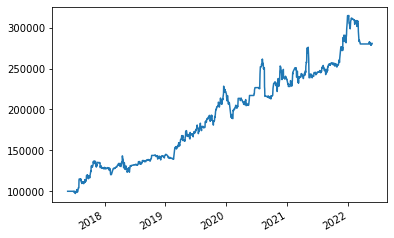

In [9]:
result_bb_rsi._equity_curve.Equity.plot()

In [10]:
result_bb_rsi_opt = bt_bb_rsi.optimize(matype=range(0, 9),
                                       n1=range(5, 20), n2=range(5, 20))
result_bb_rsi_opt._strategy

/Users/jesse/miniforge3/lib/python3.9/site-packages/backtesting/backtesting.py:1488: UserWarning: Searching for best of 2025 configurations.
  output = _optimize_grid()
/Users/jesse/miniforge3/lib/python3.9/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


  0%|          | 0/11 [00:00<?, ?it/s]

<Strategy BBands_RSI(matype=0,n1=10,n2=11)>

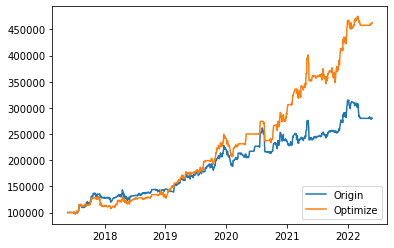

In [11]:
plt.figure()
plt.plot(result_bb_rsi._equity_curve.Equity, label='Origin')
plt.plot(result_bb_rsi_opt._equity_curve.Equity, label='Optimize')
plt.legend(loc='lower right')
plt.show()

### Chip Analysis

In [12]:
bt_bb_rsi_chip = Backtest(chip_df, BBands_RSI_chip, cash=100000, commission=0.001425, trade_on_close=True)
result_bb_rsi_chip = bt_bb_rsi_chip.run(matype=4, n1=19, n2=10)
bt_bb_rsi_chip.plot()

Row(id='2560', ...)

In [13]:
result_bb_rsi_chip = bt_bb_rsi_chip.optimize(matype=range(0, 9),
                                             n1=range(5, 20), n2=range(5, 20))
result_bb_rsi_chip._strategy

/Users/jesse/miniforge3/lib/python3.9/site-packages/backtesting/backtesting.py:1488: UserWarning: Searching for best of 2025 configurations.
  output = _optimize_grid()
/Users/jesse/miniforge3/lib/python3.9/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


  0%|          | 0/11 [00:00<?, ?it/s]

<Strategy BBands_RSI_chip(matype=4,n1=19,n2=10)>

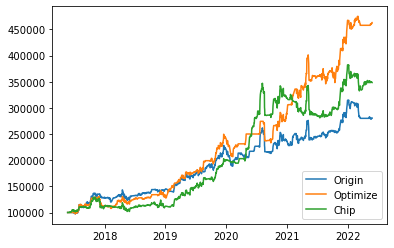

In [14]:
plt.figure()
plt.plot(result_bb_rsi._equity_curve.Equity, label='Origin')
plt.plot(result_bb_rsi_opt._equity_curve.Equity, label='Optimize')
plt.plot(result_bb_rsi_chip._equity_curve.Equity, label='Chip')
plt.legend(loc='lower right')
plt.show()